<a href="https://colab.research.google.com/github/gabrieletirrito/Paintings-Classifier-/blob/main/emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models

import keras
from keras.models import Sequential, Model
from keras import optimizers, losses, activations, models, applications
from keras.layers import Convolution2D, Dense, Input, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [ ]:
artemis = pd.read_csv('/kaggle/input/artemis-full/artemis.csv')
artemis

,Unnamed: 0,art_style,painting,emotion,utterance,repetition,path
0,0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
1,1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,/kaggle/input/wikiart/Post_Impressionism/vince...
2,2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
3,3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
4,4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,/kaggle/input/wikiart/Post_Impressionism/vince...
...,...,...,...,...,...,...,...
450550,454679,Cubism,gino-severini_a-dancer-1,awe,the collection and collage of different colors...,48,/kaggle/input/wikiart/Cubism/gino-severini_a-d...
450551,454680,Romanticism,ivan-aivazovsky_sea-at-night-1861,awe,The peaceful reflections of the moonlight on t...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...
450552,454681,Romanticism,ivan-aivazovsky_sea-at-night-1861,excitement,I can imagine the sailors resting this peacefu...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...
450553,454682,Romanticism,ivan-aivazovsky_sea-at-night-1861,contentment,The steep mountains and the moonlight provide ...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...


In [ ]:
u_emo = artemis.emotion.unique()
print(f"\n{'='*10} Unique Emotions {'='*10}\n{u_emo}\n{'='*10} Total: {len(u_emo)} {'='*10}")


========== Unique Emotions ==========
['something else' 'awe' 'contentment' 'amusement' 'sadness' 'fear'
 'excitement' 'disgust' 'anger']
========== Total: 9 ==========


# Emotion Classification

The following code snippet filters the dataset to retain only the rows where the 'emotion' column contains values that are easy to classify, excluding instances where the emotion is labeled as 'something else' to ensure smoother classification later on.

In [ ]:
artemis = artemis[artemis['emotion']!='something else']
artemis

,Unnamed: 0,art_style,painting,emotion,utterance,repetition,path
1,1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,/kaggle/input/wikiart/Post_Impressionism/vince...
3,3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
4,4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,/kaggle/input/wikiart/Post_Impressionism/vince...
5,5,Expressionism,wassily-kandinsky_study-for-autumn-1909,awe,The bright colors make a very unique scene for...,7,/kaggle/input/wikiart/Expressionism/wassily-ka...
7,7,Impressionism,konstantin-korovin_yaroslavna-s-lament-1909,awe,the stroke of blue paint used to outline the h...,7,/kaggle/input/wikiart/Impressionism/konstantin...
...,...,...,...,...,...,...,...
450550,454679,Cubism,gino-severini_a-dancer-1,awe,the collection and collage of different colors...,48,/kaggle/input/wikiart/Cubism/gino-severini_a-d...
450551,454680,Romanticism,ivan-aivazovsky_sea-at-night-1861,awe,The peaceful reflections of the moonlight on t...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...
450552,454681,Romanticism,ivan-aivazovsky_sea-at-night-1861,excitement,I can imagine the sailors resting this peacefu...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...
450553,454682,Romanticism,ivan-aivazovsky_sea-at-night-1861,contentment,The steep mountains and the moonlight provide ...,8,/kaggle/input/wikiart/Romanticism/ivan-aivazov...


The following code aims to perform binary classification, simplifying the emotion classes into two categories: positive and negative. This decision is well-founded, based on careful considerations regarding the properties and characteristics of the dataset.

In [ ]:
artemis['emotion'] = artemis['emotion'].replace(['contentment','awe','amusement','excitement'], 'positive')
artemis['emotion'] = artemis['emotion'].replace(['fear','sadness','disgust','anger'], 'negative')
artemis['emotion']

/tmp/ipykernel_164/2249963612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artemis['emotion'] = artemis['emotion'].replace(['contentment','awe','amusement','excitement'], 'positive')
/tmp/ipykernel_164/2249963612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artemis['emotion'] = artemis['emotion'].replace(['fear','sadness','disgust','anger'], 'negative')


1         negative
3         positive
4         positive
5         positive
7         positive
            ...   
450550    positive
450551    positive
450552    positive
450553    positive
450554    negative
Name: emotion, Length: 397943, dtype: object

This code snippet utilizes the _OneHotEncoder_ from the scikit-learn library to transform the categorical 'emotion' column into a one-hot encoded representation.

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_array = enc.fit_transform(artemis[['emotion']])
encoded_df = pd.DataFrame(encoded_array, index=artemis['path'])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
artemis[:5]

,Unnamed: 0,art_style,painting,emotion,utterance,repetition,path
5,5,Expressionism,wassily-kandinsky_study-for-autumn-1909,positive,The bright colors make a very unique scene for...,7,/kaggle/input/wikiart/Expressionism/wassily-ka...
7,7,Impressionism,konstantin-korovin_yaroslavna-s-lament-1909,positive,the stroke of blue paint used to outline the h...,7,/kaggle/input/wikiart/Impressionism/konstantin...
9,9,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,positive,The golden gloves and white dress stand out an...,7,/kaggle/input/wikiart/Impressionism/paul-gaugu...
11,11,Impressionism,pericles-pantazis_still-life-with-quinces-1880,positive,The pears are just about ripe to eat and enjoy,7,/kaggle/input/wikiart/Impressionism/pericles-p...
13,13,Impressionism,willard-metcalf_havana-harbor,positive,The palm trees have grown so tall they're towe...,7,/kaggle/input/wikiart/Impressionism/willard-me...


In [ ]:
encoded_df.iloc[:5]

,0,1
path,,
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_portrait-of-madame-ginoux-l-arlesienne-1890.jpg,1.0,0.0
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_portrait-of-madame-ginoux-l-arlesienne-1890.jpg,0.0,1.0
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_portrait-of-madame-ginoux-l-arlesienne-1890.jpg,0.0,1.0
/kaggle/input/wikiart/Expressionism/wassily-kandinsky_study-for-autumn-1909.jpg,0.0,1.0
/kaggle/input/wikiart/Impressionism/konstantin-korovin_yaroslavna-s-lament-1909.jpg,0.0,1.0


This code snippet preprocesses a dataset for binary classification by performing the following steps:

Grouping and Summation: It aggregates encoded values in the DataFrame by grouping observations based on the 'path' column and summing up their values.

Normalization: The aggregated values are then normalized to ensure comparability and consistent scale across observations.

Binary Classification Preparation: The dataset is filtered to retain only rows where the encoded values indicate either positive or negative class.

Finally, the target variable for binary classification is selected from the normalized DataFrame.

In [ ]:
grouped_encoding = encoded_df.groupby('path').sum()
normalized_encoding = round(grouped_encoding.div(grouped_encoding.sum(axis=1), axis=0), 2)
normalized_encoding = normalized_encoding[(normalized_encoding[0] == 1) | (normalized_encoding[1] == 1)]
normalized_encoding[:5]

,0,1
path,,
/kaggle/input/wikiart/Abstract_Expressionism/aaron-siskind_chicago-6-1961.jpg,1.0,0.0
/kaggle/input/wikiart/Abstract_Expressionism/aaron-siskind_gloucester-16a-1944.jpg,1.0,0.0
/kaggle/input/wikiart/Abstract_Expressionism/aaron-siskind_new-york-1951.jpg,1.0,0.0
/kaggle/input/wikiart/Abstract_Expressionism/aaron-siskind_new-york-24-1988.jpg,1.0,0.0
/kaggle/input/wikiart/Abstract_Expressionism/aaron-siskind_new-york-40-1986.jpg,1.0,0.0


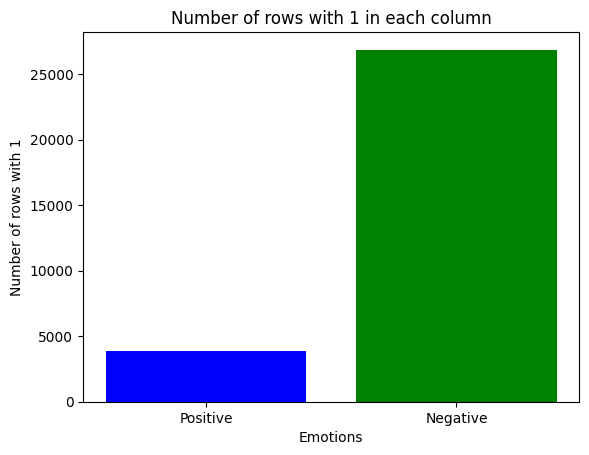

In [ ]:
positive = normalized_encoding[normalized_encoding[0] == 1].shape[0]
negative = normalized_encoding[normalized_encoding[1] == 1].shape[0]

labels = ['Positive', 'Negative']
counts = [positive, negative]

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Emotions')
plt.ylabel('Number of rows with 1')
plt.title('Number of rows with 1 in each column')
plt.show()

The code below filters rows from **normalized_encoding** based on the value of the class with more examples, creating two separate DataFrames.
1. **df_** contains rows where the emotion label is 'positive'
2. **df_1** contains a random sample of rows where the emotion label is 'negative'.

In [ ]:
df_0 = normalized_encoding[normalized_encoding[1] == 0][1]
df_1 = normalized_encoding[normalized_encoding[1] == 1][1].sample(n=3869, random_state=42)

In [ ]:
df_concatenated = pd.concat([df_0, df_1]).sample(frac=1, random_state = 42)
df_concatenated

path
/kaggle/input/wikiart/Impressionism/helene-schjerfbeck_the-seamstress-the-working-woman-1905.jpg                                                       0.0
/kaggle/input/wikiart/Cubism/willi-baumeister_tennis-1933.jpg                                                                                          0.0
/kaggle/input/wikiart/Northern_Renaissance/pieter-bruegel-the-elder_landscape-with-christ-appearing-to-the-apostles-at-the-sea-of-tiberias-1553.jpg    1.0
/kaggle/input/wikiart/Pointillism/georges-seurat_the-maria-honfleur-1886.jpg                                                                           1.0
/kaggle/input/wikiart/Cubism/pyotr-konchalovsky_sketch-a-still-life-with-guitar-1917-1.jpg                                                             1.0
                                                                                                                                                      ... 
/kaggle/input/wikiart/Impressionism/victor-borisov-musatov_spring

In [ ]:
demo = df_concatenated[:9]
df_concatenated = df_concatenated[9:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_concatenated.index, np.ndarray.astype(df_concatenated.values, np.int64).reshape(-1,1), test_size=0.2, random_state=42)

In [ ]:
def load_image(image_path):
    '''
    Args:
        image_path: A string representing the path to the image file.

    Returns:
        img: The image retrieved from the given path is read as a JPEG image with three color channels (RGB), resized to dimensions of 299x299 pixels, preprocessed using the InceptionV3 preprocessing function,
             and then returned as a NumPy array.
        img_path: The original image path.
    '''
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = img.numpy()
    return img, image_path

The code sets up TensorFlow datasets for training and validation using numpy files. Specifically:

1. It defines a map function **map_func** that loads image tensors and their corresponding labels from numpy files.
2. It creates TensorFlow datasets using _tf.data.Dataset.from_tensor_slices()_ for both training and validation, passing in the numpy arrays X_train, y_train, X_test, and y_test.
3. It uses map() to apply the map_func to each element of the datasets, ensuring that image tensors are loaded in parallel.
4. It ensures that the shape of each image tensor is (299, 299, 3) and the shape of each label tensor is (8) using _tf.ensure_shape()_.
5. It shuffles and batches the datasets using _shuffle()_ and _batch()_, respectively.
6. It prefetches elements from the datasets to improve performance using _prefetch()_ with the buffer_size set to tf.data.experimental.AUTOTUNE.

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, style):
    img_tensor = load_image(img_name.decode('utf-8'))[0]
    return img_tensor, style

dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((np.array(X_test), y_test))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda item1, item2: (tf.ensure_shape(item1, (224, 224, 3)), tf.ensure_shape(item2, (1,))))

dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.map(lambda item1, item2: (tf.ensure_shape(item1, (224, 224, 3)), tf.ensure_shape(item2, (1,))))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

The code retrieves the first batch of data from the validation dataset and prints it.

In [ ]:
first_pair = next(iter(dataset_val.take(1)))
print(first_pair)

(<tf.Tensor: shape=(64, 1920), dtype=float32, numpy=
array([[6.3884661e-05, 6.0622516e-04, 1.0889466e-03, ..., 3.2089418e-01,
        1.5201038e+00, 7.1498924e-01],
       [8.4837244e-05, 8.4266887e-04, 8.1864098e-04, ..., 5.5433875e-01,
        1.6794883e-01, 1.0989237e-01],
       [1.2442355e-04, 5.7295209e-04, 5.6551187e-04, ..., 7.5005203e-02,
        2.2224154e-01, 1.4360592e-01],
       ...,
       [2.2726077e-04, 8.8862301e-04, 1.5662413e-03, ..., 2.2599635e-01,
        3.0099145e-01, 1.4517014e-01],
       [1.1736672e-04, 4.0174153e-04, 7.6304236e-04, ..., 5.5752909e-01,
        8.8362479e-01, 1.5315062e-01],
       [6.9579612e-05, 7.3671417e-04, 1.8454647e-03, ..., 8.4527679e-02,
        1.3334599e+00, 6.3554440e-03]], dtype=float32)>, <tf.Tensor: shape=(64, 1), dtype=int64, numpy=
array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
      

The model chosen for the classification is the following.  


In [ ]:
# Load the pre-trained InceptionV3 model with weights from the ImageNet dataset
# Exclude the top fully connected layers for transfer learning
# Define the input shape as (299, 299, 3) for images
base_model = applications.InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(299, 299, 3))

# Allow training of the base model's layers
base_model.trainable = True

# Create a Sequential model for additional layers to be added on top of the base model
add_model = Sequential()

# Add a global average pooling layer to reduce spatial dimensions and provide a global summary of the features
add_model.add(GlobalAveragePooling2D())

# Add dropout layer with dropout rate of 0.3 to reduce overfitting
add_model.add(Dropout(0.3))

# Add a fully connected dense layer with 1024 units and ReLU activation function
add_model.add(Dense(1024, activation='relu'))

add_model.add(Dropout(0.3))

# Add a fully connected dense layer with 512 units and ReLU activation function
add_model.add(Dense(512, activation='relu'))

add_model.add(Dropout(0.2))

# Add a fully connected dense layer with 256 units and ReLU activation function
add_model.add(Dense(256, activation='relu'))

# Add the final output layer with 1 unit and sigmoid activation function for binary classification
add_model.add(Dense(1, activation='sigmoid'))

# Create a Sequential model to combine the base model and additional layers
model = tf.keras.Sequential([
    # Input layer with shape (299, 299, 3) for images
    tf.keras.Input(shape=(299, 299, 3)),

    # Data augmentation layers for random rotation, zoom, and translation
    keras.layers.RandomRotation(0.5),
    keras.layers.RandomZoom((0.5, 0.5), width_factor=(0.5, 0.5)),
    keras.layers.RandomTranslation(0.5, 0.5),

    # Include the pre-trained InceptionV3 base model
    base_model,

    add_model
])

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer= 'adamax',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_17 (Random  (None, 299, 299, 3)       0         
 Rotation)                                                       
                                                                 
 random_zoom_13 (RandomZoom  (None, 299, 299, 3)       0         
 )                                                               
                                                                 
 random_translation_17 (Ran  (None, 299, 299, 3)       0         
 domTranslation)                                                 
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 sequential_30 (Sequential)  (None, 1)                 2754561   
                                                     

In [ ]:
history = model.fit(dataset, epochs=10, validation_data = dataset_val)

Epoch 1/10
97/97 [==============================] - 124s 956ms/step - loss: 0.7023 - accuracy: 0.5233 - val_loss: 0.6998 - val_accuracy: 0.5013
Epoch 2/10
97/97 [==============================] - 99s 939ms/step - loss: 0.5940 - accuracy: 0.6952 - val_loss: 1.4047 - val_accuracy: 0.6150
Epoch 3/10
97/97 [==============================] - 98s 941ms/step - loss: 0.5421 - accuracy: 0.7304 - val_loss: 0.5567 - val_accuracy: 0.7028
Epoch 4/10
97/97 [==============================] - 99s 942ms/step - loss: 0.5409 - accuracy: 0.7260 - val_loss: 0.6281 - val_accuracy: 0.7106
Epoch 5/10
97/97 [==============================] - 98s 945ms/step - loss: 0.5136 - accuracy: 0.7478 - val_loss: 0.5905 - val_accuracy: 0.6951
Epoch 6/10
97/97 [==============================] - 98s 942ms/step - loss: 0.5121 - accuracy: 0.7525 - val_loss: 0.6825 - val_accuracy: 0.6641
Epoch 7/10
97/97 [==============================] - 98s 941ms/step - loss: 0.5042 - accuracy: 0.7536 - val_loss: 0.5744 - val_accuracy: 0.737

In [ ]:
model.save('model_emotion.keras')

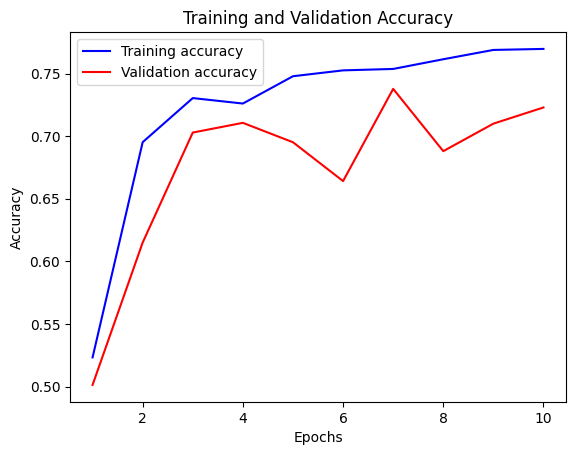

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
import numpy as np

image_model = tf.keras.applications.DenseNet201(include_top=False,
                                                weights='imagenet')

image_features_extract_model = tf.keras.Sequential()
image_features_extract_model.add(image_model)
image_features_extract_model.add(GlobalAveragePooling2D())

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, image_path

In [ ]:
file_paths = list(set(df_concatenated.index.tolist()))
dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

print(f"Size of the dataset: {dataset_size}")

image_dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

my_dict = {}

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        my_dict[path_of_feature] = (bf.numpy(),df_concatenated[path_of_feature] )

Size of the dataset: 7738


100%|██████████| 121/121 [01:04<00:00,  1.89it/s]


In [ ]:
X = np.array([data[0] for data in my_dict.values()])
Y = np.array([data[1] for data in my_dict.values()])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (6190, 1920)
X_test shape: (1548, 1920)
Y_train shape: (6190,)
Y_test shape: (1548,)


In [ ]:
log_reg_classifier = LogisticRegression(max_iter = 1000)
knn_classifier = KNeighborsClassifier(n_neighbors=20)
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_classifier = XGBClassifier()

ensemble = VotingClassifier(estimators=[
    ('log_reg', log_reg_classifier),
    ('knn', knn_classifier),
    ('rf', rf_classifier),
    ('xgb', xgb_classifier)
], voting='hard')

ensemble.fit(X_train, Y_train)
y_pred = ensemble.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7932816537467701


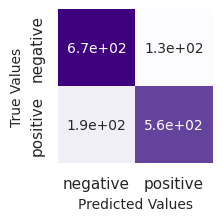

In [ ]:
cm = confusion_matrix(Y_test, y_pred)

fig = plt.figure(figsize = (2,2))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, annot_kws={"size": 10},
     cbar = False, cmap='Purples', xticklabels=enc.categories_[0].tolist(), yticklabels=enc.categories_[0].tolist());
ax1.set_ylabel('True Values',fontsize=10)
ax1.set_xlabel('Predicted Values',fontsize=10)
plt.show()

In [ ]:
features_demo = []
for img_path in demo.index:
    img = load_image(img_path)
    img = tf.expand_dims(img[0], axis=0)
    img_features = image_features_extract_model(img)
    features_demo.append(img_features.numpy().squeeze())

In [ ]:
y_demo = ensemble.predict(features_demo)
y_demo_p = pd.Series(y_demo).replace({0: 'Negative', 1: 'Positive'})
y_demo_t = pd.Series(demo.values).replace({0: 'Negative', 1: 'Positive'})

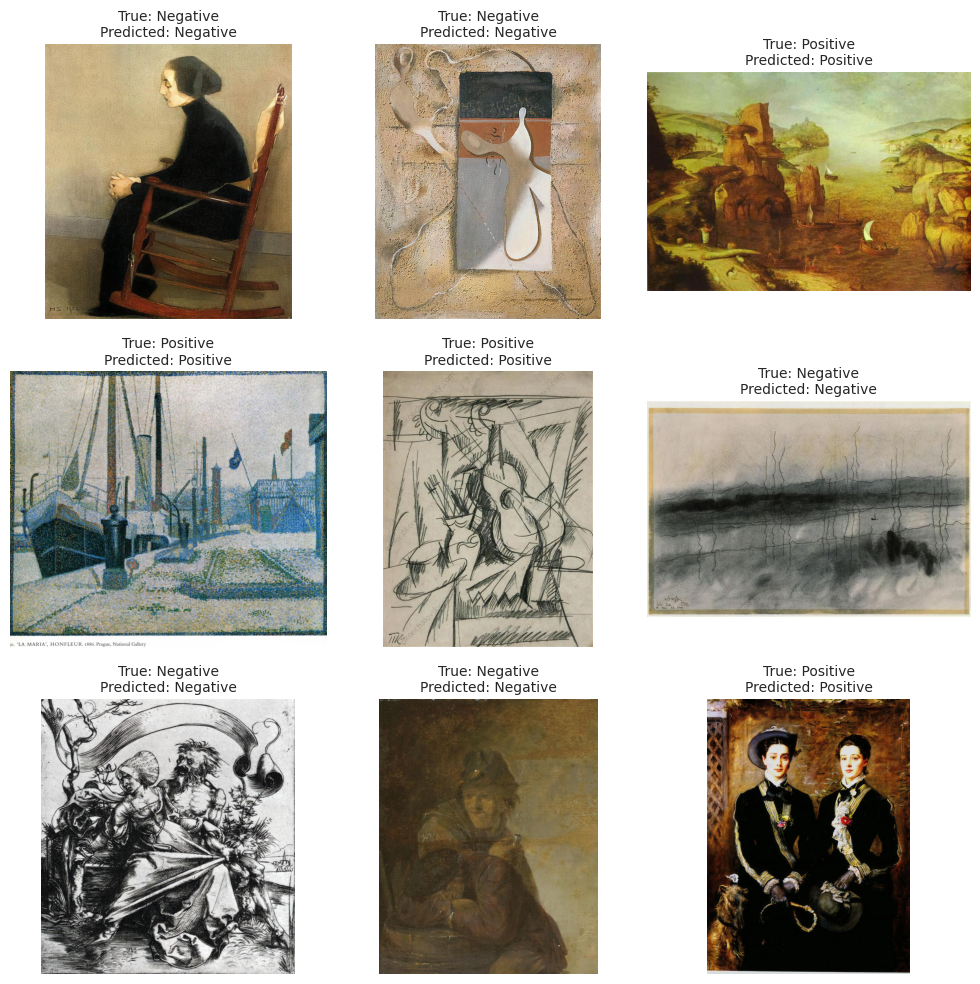

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, (path, label, pred) in enumerate(zip(demo.index, y_demo_t, y_demo_p)):
    row = i // 3
    col = i % 3
    img = mpimg.imread(path)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label}\nPredicted: {pred}", fontsize=10, pad=5)

plt.tight_layout()
plt.show()